In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import numpy as np
import glob
import re
import os
import tensorflow as tf

sess = tf.InteractiveSession()

In [38]:
if not os.path.exists('trainingData.p'):
    train = pd.read_csv('data/train.csv', index_col=0, dtype='object')

    trainData = []

    marginCols = ['margin{0}'.format(i) for i in range(1, 65)]
    textureCols = ['texture{0}'.format(i) for i in range(1, 65)]
    shapeCols = ['shape{0}'.format(i) for i in range(1, 65)]

    ## Generate one hot encoding for species
    classNames = sorted(np.unique(train['species']))
    numClasses = len(classNames)
    labelMap = {k:i for i,k in enumerate(classNames)}

    def downsampleByTwo(img):
        tmp = np.array(img)
        # if the number of rows is odd, pad with a row of zeros
        if (tmp.shape[0] & 0x01):
            tmp = np.vstack([tmp, np.zeros((1, tmp.shape[1]))])

        if (tmp.shape[1] & 0x01):
            tmp = np.hstack([tmp, np.zeros((tmp.shape[0], 1))])

        ret = np.zeros(np.array(tmp.shape) / 2)

        for i in range(tmp.shape[0]):
            for j in range(tmp.shape[1]):
                ret[i/2,j/2] = .25 * tmp[i,j]

        return ret

    def preprocessImage(img):
        blurred = ndimage.gaussian_filter(img, 3)    
        ds = downsampleByTwo(blurred)
        ds = downsampleByTwo(ds)
        ds = downsampleByTwo(ds)
        return ds

    columnGroups = [marginCols, textureCols, shapeCols]
    for r in train.iterrows():
        caseId = r[0]
        trainData.append([caseId])
        # Generate one hot encoding for species
        oneHot = np.zeros((numClasses,))
        oneHot[labelMap[r[1]['species']]] = 1.0
        classId = labelMap[r[1]['species']]
        trainData[-1].append(classId)
        trainData[-1].append(oneHot)

        for col in columnGroups:
            curr = r[1][col]
            trainData[-1].append(np.array(curr))

        img = ndimage.imread('data/images/{0}.jpg'.format(caseId)) / 255.0
        img = preprocessImage(img)
        img = np.expand_dims(img, -1)
        trainData[-1].append(img)
        trainData[-1].append(img.shape[0])
        trainData[-1].append(img.shape[1])
    trainData = pd.DataFrame(trainData, columns=['caseId', 'classId', 'oneHot', 'margin', 
                                                 'textureCols', 'shape',
                                                 'img', 'height', 
                                                 'width'])
    pd.to_pickle(trainData, 'trainingData.p')
else:
    trainData = pd.read_pickle('trainingData.p')
    
class LeafData:
    '''
    Takes in a dataframe of samples
    '''
    def __init__(self, data, testSplit, numClasses=None):
        if numClasses:
            self.numClasses = numClasses
        else:
            self.numClasses = np.max(data.iloc[0]['oneHot'].shape)
            
        data = data[data['classId'] < self.numClasses]
        
        numItems = len(data)
        numTestItems = int(numItems * testSplit)
        testSelector = np.random.choice(numItems, numTestItems,
                                        replace=False)
        self._testCases = data.iloc[testSelector].copy(deep=True)
        trainCaseSelector = list(set(range(numItems)) - set(testSelector))
        self._trainCases = data.iloc[trainCaseSelector].copy(deep=True)
                
        self._trainIndex = 0
        
        self._maxWidth = np.max(data['width'])
        self._maxHeight = np.max(data['height'])

        # Define the height as around twice the max image height/width
        # but make sure it's divisible by 4
        self.normImgWidth = 128
        self.normImgHeight = 128

        
    
    def getTrainBatch(self, n):
        y = np.zeros((n, self.numClasses))
        img = np.zeros((n, self.normImgHeight, self.normImgWidth, 1))
        
        for i in range(n):
            currCase = self._trainCases.iloc[self._trainIndex]
            currImg = np.squeeze(currCase['img'])
            rot = np.random.random(1) * 360
            currImg = ndimage.rotate(currImg, rot)
            imgHeight = currImg.shape[0]
            imgWidth = currImg.shape[1]
            currImg = np.expand_dims(currImg, -1)

            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim, 1))
            
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currImg
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim, 1)
            img[i, :, :, :] = ndimage.zoom(tmpImg, targetSize)

            y[i, :] = currCase['oneHot'][:self.numClasses]
            self._trainIndex += 1
            
            if self._trainIndex == len(self._trainCases):
                self._trainIndex = 0
                self._trainCases = self._trainCases.sample(frac=1.0)
        return img, y
    
    def getTestData(self):
        y = np.zeros((len(self._testCases), self.numClasses))
        img = np.zeros((len(self._testCases), self.normImgHeight, self.normImgWidth, 1))
        for i in range(len(self._testCases)):
            currCase = self._trainCases.iloc[self._trainIndex]
            imgHeight = currCase['height']
            imgWidth = currCase['width']
            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim, 1))
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currCase['img']
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim, 1)
            img[i, :, :, :] = ndimage.zoom(tmpImg, targetSize)

            y[i, :] = currCase['oneHot'][:self.numClasses]
            self._trainIndex += 1
        return img, y
        
        
data = LeafData(trainData, .3, numClasses=2)


In [39]:
data._trainCases

,caseId,classId,oneHot,margin,textureCols,shape,img,height,width
89,160,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0.007812, 0.029297, 0, 0.009766, 0, ...","[0.020508, 0, 0.006836, 0.001953, 0.09375, 0, ...","[0.00072796, 0.00070604, 0.00071365, 0.0006808...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",64,74
91,164,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0.011719, 0.041016, 0, 0.007812, 0, ...","[0.055664, 0, 0.00293, 0.008789, 0.02832, 0, 0...","[0.00074494, 0.00075464, 0.00074901, 0.0007104...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",64,71
93,166,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0.009766, 0.017578, 0, 0.001953, 0, ...","[0.020508, 0, 0.001953, 0, 0.056641, 0, 0.0273...","[0.00065656, 0.00065709, 0.00062547, 0.0006056...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",64,71
111,201,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001953, 0, 0.017578, 0.001953, 0.054688, 0....","[0.005859, 0.036133, 0.021484, 0, 0.048828, 0....","[0.00060131, 0.0006253, 0.00062085, 0.00063045...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",50,82
154,268,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0.021484, 0.035156, 0, 0.007812, 0, ...","[0.037109, 0.000977, 0.000977, 0.000977, 0.064...","[0.00069753, 0.00073194, 0.00073198, 0.0007260...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",62,69
302,496,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0.021484, 0.033203, 0, 0.005859, 0, ...","[0.026367, 0.00293, 0.003906, 0.00293, 0.08398...","[0.00067599, 0.00066195, 0.00063242, 0.0006031...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",66,71
347,569,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001953, 0, 0.011719, 0.013672, 0.033203, 0,...","[0.005859, 0.053711, 0.018555, 0.009766, 0.034...","[0.00061978, 0.00063273, 0.00062642, 0.0006359...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",51,81
370,610,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001953, 0.001953, 0.025391, 0.017578, 0.029...","[0.004883, 0.061523, 0.021484, 0.000977, 0.045...","[0.00063028, 0.00066074, 0.00071871, 0.0006514...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",48,86
607,962,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0.003906, 0.011719, 0.029297, 0, 0.0078...","[0.02832, 0, 0.007812, 0.007812, 0.043945, 0, ...","[0.00073691, 0.00070741, 0.00068733, 0.0006766...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",66,72
631,1000,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0.007812, 0.027344, 0, 0.001953, 0, ...","[0.024414, 0.000977, 0.008789, 0.001953, 0.090...","[0.00069599, 0.0007191, 0.00070832, 0.00068665...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",64,74


In [40]:
data._testCases

,caseId,classId,oneHot,margin,textureCols,shape,img,height,width
126,227,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001953, 0, 0.017578, 0.013672, 0.027344, 0,...","[0, 0.058594, 0.016602, 0, 0.14258, 0.005859, ...","[0.00060125, 0.00062882, 0.00063325, 0.0006356...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",50,77
130,235,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001953, 0.005859, 0.005859, 0.017578, 0.035...","[0.020508, 0.000977, 0.004883, 0, 0.074219, 0,...","[0.00076258, 0.0007626, 0.00072972, 0.00072095...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",68,72
624,990,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001953, 0, 0.009766, 0.019531, 0.03125, 0.0...","[0, 0.060547, 0.03125, 0, 0.10449, 0.015625, 0...","[0.00061271, 0.00056928, 0.00056431, 0.0006072...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",51,78
951,1525,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0.013672, 0.015625, 0.035156, 0, 0.0234...","[0, 0.058594, 0.017578, 0, 0.099609, 0.015625,...","[0.00059946, 0.0005524, 0.00055795, 0.00056888...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",54,79
859,1377,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001953, 0, 0.011719, 0.029297, 0.033203, 0,...","[0, 0.056641, 0.015625, 0, 0.086914, 0.004883,...","[0.00055321, 0.00058276, 0.00052074, 0.0005749...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",53,79
304,498,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0.021484, 0.037109, 0.029297, 0, 0.0410...","[0, 0.048828, 0.020508, 0, 0.083008, 0.004883,...","[0.00061634, 0.00061527, 0.0006056, 0.00056823...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",54,78


<IPython.core.display.Javascript object>


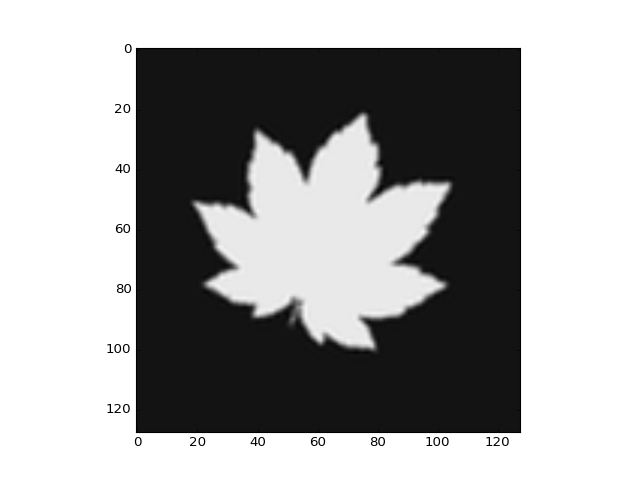

In [50]:
plt.figure()
img, label = data.getTrainBatch(1)
plt.imshow(np.squeeze(img), cmap='gray')

In [44]:

learningRate = 1e-7

print 'Defining Graph'

def weight_variable(shape, name=None): 
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name=None):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
    print 'Conv2D x', x
    print 'Conv2D W', W
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    print 'Max_pool x', x
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME', name=name)

def convLayer(x, w, b, name=None):
    conv = tf.nn.relu(conv2d(x, w, name=name+'_conv2d') + b, name=name+'_relu')
    pool = max_pool_2x2(conv, name=name+'_maxPool')
    print 'convLayer pool', pool
    return pool

x = tf.placeholder(tf.float32, shape=[None, data.normImgHeight, data.normImgWidth, 1], name='imgPlaceHolder')
labels = tf.placeholder(tf.float32, shape=[None, data.numClasses], name='labelPlaceHolder')

## Layer definitions
# Layer 1 - Convolutional
kernelSize = 3
numOutputs = 32
numInputChannels = 1
W_conv1 = weight_variable([kernelSize, kernelSize, 
                           numInputChannels, numOutputs], name='w_conv1')
b_conv1 = bias_variable([numOutputs], name='b_conv1')

pool1 = convLayer(x, W_conv1, b_conv1, name='pool1')

outputWidth = data.normImgWidth / 2
outputHeight = data.normImgHeight / 2

# Layer 2 - Convolutional
kernelSize = 3
numInputChannels = numOutputs
numOutputs = 32

W_conv2 = weight_variable([kernelSize, kernelSize,
                           numInputChannels, numOutputs], name='w_conv2')
b_conv2 = bias_variable([numOutputs], name='b_conv2')

pool2 = convLayer(pool1, W_conv2, b_conv2, name='pool2')

outputWidth = outputWidth / 2
outputHeight = outputHeight / 2

# Layer 3 - Convolutional
kernelSize = 3
numInputChannels = numOutputs
numOutputs = 32

W_conv3 = weight_variable([kernelSize, kernelSize,
                           numInputChannels, numOutputs], name='w_conv3')
b_conv3 = bias_variable([numOutputs], name='b_conv3')

pool3 = convLayer(pool2, W_conv3, b_conv3, name='pool3')

outputWidth = outputWidth / 2
outputHeight = outputHeight / 2

# # Layer 4 - Convolutional
kernelSize = 3
numInputChannels = numOutputs
numOutputs = 32

W_conv4 = weight_variable([kernelSize, kernelSize,
                           numInputChannels, numOutputs], name='w_conv4')
b_conv4 = bias_variable([numOutputs], name='b_conv4')

pool4 = convLayer(pool3, W_conv4, b_conv4, name='pool4')

outputWidth = outputWidth / 2
outputHeight = outputHeight / 2


# Layer 4 - Fully connected
fcNeurons = 1024
print outputWidth, outputHeight
W_fc1 = weight_variable([outputWidth * outputHeight * numOutputs, fcNeurons], name='w_fc1')
b_fc1 = bias_variable([fcNeurons], name='b_fc1')

pool4_flat = tf.reshape(pool4, [-1, outputWidth * outputHeight * numOutputs], name='flatten')
fc1 = tf.nn.relu(tf.matmul(pool4_flat, W_fc1, name='fc1_matmul') + b_fc1, name='fc1_relu')
print 'Pool4', pool4
print 'Pool4_flat', pool4_flat, outputWidth, outputHeight, numOutputs


# Layer 4 - Dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
dropout = tf.nn.dropout(fc1, keep_prob, name='dropoutLayer')

# Layer 5 - Readout
W_fc2 = weight_variable([fcNeurons, data.numClasses], name='w_fc2')
b_fc2 = bias_variable([data.numClasses], name='b_fc2')
y_conv = tf.matmul(dropout, W_fc2, name='y_conv') + b_fc2



# Define loss function
print 'Defining Loss Function'
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=labels, name='sm_cewl'))
train_step = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print 'Initializing Vars'
sess.run(tf.global_variables_initializer())

print 'Starting Learning'
for i in range(1000):
    img, y = data.getTrainBatch(10)
    
    if i % 10 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: img,
            labels: y,
            keep_prob: 1.0
        })
        
        xentropy = cross_entropy.eval(feed_dict={
            x: img,
            labels: y,
            keep_prob: 1.0
        })
        print ('Step: {0} Training Accuracy: {1} Entropy: {2}'.format(i, train_accuracy, xentropy))
    train_step.run(feed_dict={
        x: img,
        labels: y,
        keep_prob: 1.0
    })


Defining Graph
Conv2D x Tensor("imgPlaceHolder_5:0", shape=(?, 128, 128, 1), dtype=float32)
Conv2D W Tensor("w_conv1_5/read:0", shape=(3, 3, 1, 32), dtype=float32)
Max_pool x Tensor("pool1_relu_5:0", shape=(?, 128, 128, 32), dtype=float32)
convLayer pool Tensor("pool1_maxPool_5:0", shape=(?, 64, 64, 32), dtype=float32)
Conv2D x Tensor("pool1_maxPool_5:0", shape=(?, 64, 64, 32), dtype=float32)
Conv2D W Tensor("w_conv2_5/read:0", shape=(3, 3, 32, 32), dtype=float32)
Max_pool x Tensor("pool2_relu_5:0", shape=(?, 64, 64, 32), dtype=float32)
convLayer pool Tensor("pool2_maxPool_5:0", shape=(?, 32, 32, 32), dtype=float32)
Conv2D x Tensor("pool2_maxPool_5:0", shape=(?, 32, 32, 32), dtype=float32)
Conv2D W Tensor("w_conv3_5/read:0", shape=(3, 3, 32, 32), dtype=float32)
Max_pool x Tensor("pool3_relu_5:0", shape=(?, 32, 32, 32), dtype=float32)
convLayer pool Tensor("pool3_maxPool_5:0", shape=(?, 16, 16, 32), dtype=float32)
Conv2D x Tensor("pool3_maxPool_5:0", shape=(?, 16, 16, 32), dtype=float32

KeyboardInterrupt: 

In [ ]:
272 * 408 * 32 * 2

In [ ]:
np.max(trainData.iloc[0]['oneHot'].shape)

In [ ]:
a = np.array([1,2,3])

In [ ]:
a.shape

In [ ]:
np.expand_dims(a, 0).shape

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())